In [1]:
"""
Code Description:

"""

'\nCode Description:\n\n'

# Import the dependencies

In [2]:
import os
import sys
from pathlib import Path
from typing import Tuple, Union, NamedTuple, Sequence, Dict, Any
import copy
import pickle

import pandas as pd
import numpy as np
import geopandas
import pygmt
from shapely import geometry, Point, Polygon
import xarray as xr
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

sys.path.append(str(Path.cwd().parent))
from utils import util
# import seismic_hazard_analysis as sha
import utils.seismic_hazard_analysis.seismic_hazard_analysis as sha
from qcore import nhm
from qcore import coordinates as coords
from pygmt_helper import plotting

/usr/local/bin/gmt: symbol lookup error: /usr/local/bin/gmt: undefined symbol: sig_handler_unix
/mnt/hypo_data/mab419/cs100/cybershake_investigation/utils/seismic_hazard_analysis/seismic_hazard_analysis/site_source.py:928: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  scenario_section_ids[i],


# Path and directory works

In [3]:
file_path = Path.cwd()
root_path = file_path.parent.parent  # dpath to root of the project

sim_dir = root_path / "Cybershake_Data" # dpath to simulation data
base_dir = root_path / "cybershake_investigation/base_data" # dpath to dirctory of base data
map_data_ffp = Path("/home/mab419/git_clone/qcore/qcore/data/") # path to qcore/qcore/data

fault_erf_ffp = base_dir / "NZ_FLTmodel_2010.txt" #dpath to NZ fault model
background_ffp = base_dir / "NZBCK211_OpenSHA.txt" # dpath to background seismicity
station_files = {
    "stations_ll": "non_uniform_whole_nz_with_real_stations-hh400_v20p3_land.ll",
    "stations_vs30": "non_uniform_whole_nz_with_real_stations-hh400_v20p3_land.vs30",
    "stations_z": "non_uniform_whole_nz_with_real_stations-hh400_v20p3_land.z",
}

plot_dir = root_path / "cybershake_investigation/plots/old_runs_investigation"  # dpath to directory for plots
plot_dir.mkdir(parents=True, exist_ok=True)  # create the directory if it does not exist

# Define Global Functions

In [4]:
def round_up_np(value, decimals=1):
    factor = 10 ** decimals
    return np.ceil(value * factor) / factor

In [5]:
def estimate_number_of_realizations(
    mw: float,
):
    """
    Estimate the number of realizations for a given magnitude.
    """
    # Get the number of realizations for the given magnitude
    if mw < 6.0:
        num_realizations = 10,
    else:
        num_realizations = 20 * mw - 110

    return round_up_np(num_realizations, decimals=0)
    

In [6]:
import geopandas
from shapely.geometry import Point

def find_closest_station(stations_df, target_lon, target_lat):
    """
    Find the closest station using accurate distance in projected NZ coordinates.

    Parameters:
    - stations_df: DataFrame with 'long' and 'lat', the output of util.get_station_data
    - target_lon: float, longitude of the point
    - target_lat: float, latitude of the point

    Returns:
    - pandas Series for the closest station
    """
    # 1. Convert station points to GeoDataFrame
    gdf = geopandas.GeoDataFrame(
        stations_df.copy(),
        geometry=geopandas.points_from_xy(stations_df["long"], stations_df["lat"]),
        crs="EPSG:4326"  # WGS84 (lat/lon)
    )

    # 2. Project to NZ Transverse Mercator (for accurate distances in meters)
    gdf = gdf.to_crs("EPSG:2193")

    # 3. Create target point and project it
    target_point = geopandas.GeoSeries([Point(target_lon, target_lat)], crs="EPSG:4326").to_crs("EPSG:2193").iloc[0]

    # 4. Compute distances and find closest
    distances = gdf.geometry.distance(target_point)
    closest_idx = distances.idxmin()
    return gdf.loc[closest_idx], distances[closest_idx]

In [7]:
class NZMapData(NamedTuple):
    road_df: pd.DataFrame = None
    highway_df: geopandas.GeoDataFrame = None
    coastline_df: geopandas.GeoDataFrame = None
    water_df: geopandas.GeoDataFrame = None
    topo_grid: xr.DataArray = None
    topo_shading_grid: xr.DataArray = None

    @classmethod
    def load(cls, qcore_data_dir: Path, high_res_topo: bool = False):
        road_ffp = qcore_data_dir / "Paths/road/NZ.gmt"
        highway_ffp = qcore_data_dir / "Paths/highway/NZ.gmt"
        coastline_ffp = qcore_data_dir / "Paths/coastline/NZ.gmt"
        water_ffp = qcore_data_dir / "Paths/water/NZ.gmt"

        if high_res_topo:
            topo_ffp = qcore_data_dir / "Topo/srtm_NZ_1s.grd"
            topo_shading_ffp = qcore_data_dir / "Topo/srtm_NZ_1s_i5.grd"
        else:
            topo_ffp = qcore_data_dir / "Topo/srtm_NZ.grd"
            topo_shading_ffp = qcore_data_dir / "Topo/srtm_NZ_i5.grd"

        return cls(
            road_df=geopandas.read_file(road_ffp),
            highway_df=geopandas.read_file(highway_ffp),
            coastline_df=geopandas.read_file(coastline_ffp),
            water_df=geopandas.read_file(water_ffp),
            topo_grid=pygmt.grdclip(grid=str(topo_ffp), below=[0.1, np.nan]),
            topo_shading_grid=pygmt.grdclip(
                grid=str(topo_shading_ffp), below=[0.1, np.nan]
            ),
        )


DEFAULT_PLT_KWARGS = dict(
    road_pen_width=0.01,
    highway_pen_width=0.5,
    coastline_pen_width=0.05,
    topo_cmap="gray",
    topo_cmap_min=-3000,
    topo_cmap_max=3000,
    topo_cmap_inc=10,
    topo_cmap_reverse=True,
    frame_args=["af", "xaf+lLongitude", "yaf+lLatitude"],
)


def gen_region_fig(
    title: str = None,
    region: Union[str, Tuple[float, float, float, float]] = "NZ",
    projection: str = f"M17.0c",
    map_data: NZMapData = None,
    coastline_color: str = "grey",
    coastline_pen_width: str = "0.1p",
    plot_roads: bool = True,
    plot_highways: bool = True,
    plot_topo: bool = True,
    plot_kwargs: Dict[str, Any] = None,
    config_options: Dict[str, Union[str, int]] = None,
):
    """
    Creates a basic figure for the specified region
    and plots the coastline (and roads & topo if specified)
    Grabbed from "pygmt_helper/pygmt_helper/plotting.py" and customized for this script

    Parameters
    ----------
    title: str, optional
        Title of the figure
    region: str or Tuple of 4 floats
        Region to plot, either a string or
        a tuple of 4 floats in the format
        (min_lon, max_lon, min_lat, max_lat)
    projection: str
        Projection string, see pygmt or gmt
        documentation for this
    map_data: NZMapData
        Custom map data from qcore
    plot_roads: bool, optional
    plot_highways: bool, optional
    plot_topo: bool, optional
    plot_kwargs: dictionary
        Extra plotting arguments, see DEFAULT_PLT_KWARGS
        for available options

        Note: Only need to specify the ones to override
    config_options: dictionary
        Config options to be applied to the figure
        See https://docs.generic-mapping-tools.org/latest/gmt.conf.html
        for list of availbale config options

    Returns
    -------
    fig: Figure
    """
    # Merge with default
    plot_kwargs = (
        copy.deepcopy(DEFAULT_PLT_KWARGS)
        if plot_kwargs is None
        else {**DEFAULT_PLT_KWARGS, **plot_kwargs}
    )

    if title is not None:
        if plot_kwargs["frame_args"] is None:
            plot_kwargs["frame_args"] = [f'+t"{title}"']
        else:
            plot_kwargs["frame_args"].append(f'+t"{title}"')

    fig = pygmt.Figure()

    if config_options is not None:
        pygmt.config(**config_options)

    fig.basemap(region=region, projection=projection, frame=plot_kwargs["frame_args"])

    # Plots the default coast (sea & inland lakes/rivers)
    if map_data is None:
        fig.coast(
            shorelines=[f"1/{coastline_pen_width},{coastline_color}", f"2/{coastline_pen_width},{coastline_color}"],
            resolution="f",
            land=None, #"#666666" "#F5E8D3"
            water=None, #'#D1F6FF'
        )
    # Use the custom NZ data
    else:
        _draw_map_data(
            fig,
            map_data,
            plot_topo=plot_topo,
            plot_roads=plot_roads,
            plot_highways=plot_highways,
            plot_kwargs=plot_kwargs,
        )

    return fig


def _draw_map_data(
    fig: pygmt.Figure,
    map_data: Union[NZMapData, None],
    plot_topo: bool = True,
    plot_roads: bool = True,
    plot_highways: bool = True,
    plot_kwargs: Dict[str, Union[str, int]] = None,
):
    # Plot coastline and background water
    water_bg = geopandas.GeoSeries(
        geometry.LineString(
            [
                (fig.region[0], fig.region[2]),
                (fig.region[1], fig.region[2]),
                (fig.region[1], fig.region[3]),
                [fig.region[0], fig.region[3]],
            ]
        )
    )
    fig.plot(water_bg, fill="lightblue", straight_line=True)
    fig.plot(
        data=map_data.coastline_df,
        pen=f"{plot_kwargs['coastline_pen_width']}p,black",
        # fill="lightgray",
    )

    # Add topo
    if plot_topo:
        pygmt.makecpt(
            series=(
                plot_kwargs["topo_cmap_min"],
                plot_kwargs["topo_cmap_max"],
                plot_kwargs["topo_cmap_inc"],
            ),
            continuous=False,
            cmap=plot_kwargs["topo_cmap"],
            reverse=plot_kwargs["topo_cmap_reverse"],
        )
        fig.grdimage(
            grid=map_data.topo_grid,
            shading=map_data.topo_shading_grid,
            cmap=True,
            # nan_transparent=True,
        )
        fig.coast(
            shorelines=["1/0.1p,black", "2/0.1p,black"],
            resolution="f",
            land=None,
            water="lightblue",  # "lightblue", #skyblue, #DEEBFC
        )

    # Plot water
    fig.plot(data=map_data.water_df, fill="lightblue")

    # Add roads
    if plot_roads:
        fig.plot(data=map_data.road_df, pen=f"{plot_kwargs['road_pen_width']}p,white")
    if plot_highways:
        fig.plot(
            data=map_data.highway_df,
            pen=f"{plot_kwargs['highway_pen_width']}p,yellow",
        )



# Load Basic data

## Loading Stations Data

In [8]:
# get all stations data
stations_df = util.get_station_data(
    str(base_dir / station_files["stations_ll"]),
    str(base_dir / station_files["stations_vs30"]),
    str(base_dir / station_files["stations_z"]),
)

In [9]:
len(stations_df)

25948

## Loading  Fault ERF

In [10]:
flt_erf_df = nhm.load_nhm_df(fault_erf_ffp)
flt_erf = nhm.load_nhm(fault_erf_ffp)
faults_all = {
    cur_name: sha.nshm_2010.get_fault_objects(cur_fault)
    for cur_name, cur_fault in flt_erf.items()
}
list_faults_all = list(faults_all.keys())

## Loading South Island Fault List

In [11]:
faults_south_island_fp = base_dir / "faults_south_island.txt"
with open(faults_south_island_fp, "r") as f:
    list_faults_si = [line.strip() for line in f if line.strip() in list_faults_all]

In [12]:
print(f"Number of faults in South Island File that Supposed to Run ------> {len(list_faults_si)}")

Number of faults in South Island File that Supposed to Run ------> 164


# Define Versions

In [13]:
versions = [
    "v21p1",
    "v21p6",
    "v21p6p2",
    "v22p2",
    "v22p4",
    "v23p5",
    "v23p7",
    "v23p10",
]

realization_tags = {
    "v21p1": "incomplete",
    "v21p6": "incomplete",
    "v21p6p2": "incomplete",
    "v22p2": "incomplete",
    "v22p4": "good",
    "v23p5": "good",
    "v23p7": "good",
    "v23p10": "good",
}

# Create Fault_Version Metadata

In [14]:
FV = pd.DataFrame(index=list_faults_si, columns=versions)
# versions = ["v21p1"]
for version in versions:
    temp_faults = [cur_dir.stem for cur_dir in Path(sim_dir / version).iterdir() if cur_dir.is_dir()]
    for f in temp_faults:
        if f not in list_faults_all:
            print(f"CAUTION: Fault {f} not found in the All Faults List in will be skipped")
            continue
        
        if f not in list_faults_si:
            print(f"Fault {f} not found in the South Island Faults List and will be added to the Metadata")
            list_faults_si.append(f)

        number_of_realizations = len(list(Path(sim_dir / version / f / "IM").glob(f"{f}_REL*.csv")))
        FV.loc[f, version] = number_of_realizations
        
for f in FV.index:
    FV.loc[f, "number_of_realizations"] = FV.loc[f, :].dropna().sum()
    FV.loc[f, "versions"] = ", ".join(FV.loc[f, versions].dropna().index.tolist())
    if FV.loc[f, "number_of_realizations"] == 0:
        FV.loc[f, "realization_tag"] = "undone"
    else:
        ver = FV.loc[f, "versions"]
        if "," in ver:
            FV.loc[f, "realization_tag"] = "mixed"
        else:
             FV.loc[f, "realization_tag"] = realization_tags.get(FV.loc[f, "versions"], "unknown")
   
# Merge with the fault_ERF DataFrame to get the moment magnitudes
FV = FV.merge(flt_erf_df[["mw"]], how="left", left_index=True, right_index=True, suffixes=("", "_erf"))



# Estimate the expected number of realizations
FV["expected_number_of_realizations"] = FV["mw"].apply(estimate_number_of_realizations)

FV["residual_number_of_realizations"] = FV["expected_number_of_realizations"] - FV["number_of_realizations"]



In [15]:
FV['name'] = FV.index

#reorder columns
cols = FV.columns.tolist()
cols.remove('name')
new_order = ['name'] + cols[8:] + cols[:8]
FV = FV[new_order]
# Ensure 'mw' is not already first or second to avoid duplication
cols = FV.columns.tolist()
cols.remove('mw')
cols.insert(1, 'mw')  # Insert 'mw' at position 1 (second column)
FV = FV[cols]


# FV

In [16]:
FV

,name,mw,number_of_realizations,versions,realization_tag,expected_number_of_realizations,residual_number_of_realizations,v21p1,v21p6,v21p6p2,v22p2,v22p4,v23p5,v23p7,v23p10
AhuririR,AhuririR,7.19,30.0,v21p6p2,incomplete,34.0,4.0,NaN,NaN,30,NaN,NaN,NaN,NaN,NaN
Akatore,Akatore,7.42,33.0,v21p6p2,incomplete,39.0,6.0,NaN,NaN,33,NaN,NaN,NaN,NaN,NaN
Albury,Albury,6.68,42.0,"v21p6p2, v23p5",mixed,24.0,-18.0,NaN,NaN,21,NaN,NaN,21,NaN,NaN
AlpineF2K,AlpineF2K,8.10,47.0,v23p7,good,52.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,47,NaN
AlpineK2T,AlpineK2T,7.66,41.0,v21p1,incomplete,44.0,3.0,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wairau,Wairau,7.78,37.0,v21p1,incomplete,46.0,9.0,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Waitangi,Waitangi,6.52,38.0,"v21p6p2, v23p5",mixed,21.0,-17.0,NaN,NaN,19,NaN,NaN,19,NaN,NaN
Waitohi,Waitohi,7.07,56.0,"v21p6p2, v23p10",mixed,32.0,-24.0,NaN,NaN,28,NaN,NaN,NaN,NaN,28
WharaToCampB,WharaToCampB,7.22,30.0,v22p4,good,35.0,5.0,NaN,NaN,NaN,NaN,30,NaN,NaN,NaN


# Plot Fault Traces

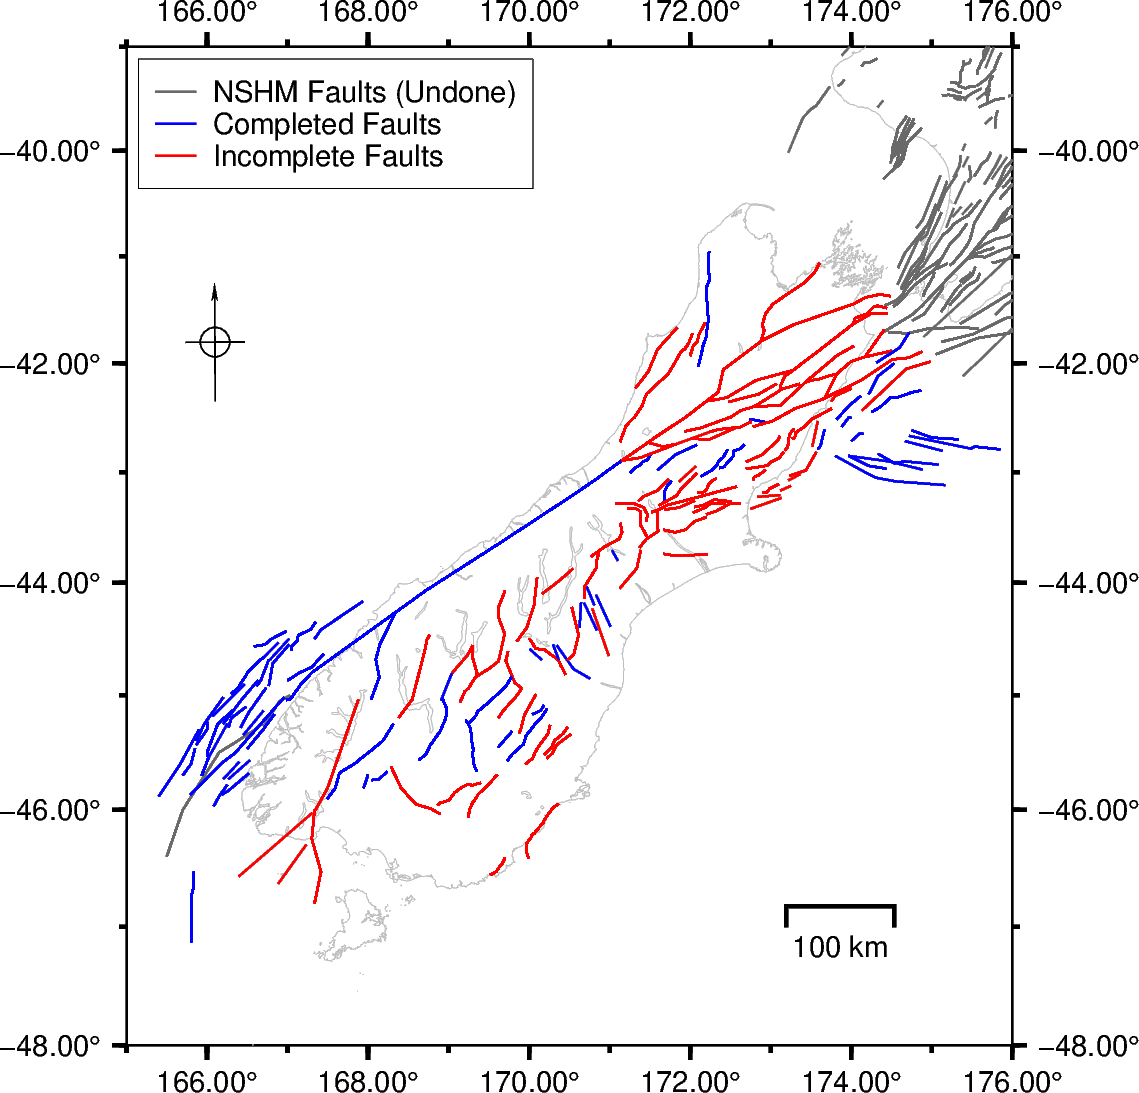

In [17]:
plot_using_mapdata = False

if plot_using_mapdata == True:
    # loading the mapdata
    map_data = (
        plotting.NZMapData.load(map_data_ffp) if map_data_ffp is not None else None
    )
else:
    map_data = None

fig = gen_region_fig(
    title=None,
    region=[165, 176, -48, -39],
    projection="M7.5c",
    map_data=map_data,
    plot_topo=True,
    plot_roads=False,
    plot_highways=False,
    plot_kwargs={
        "highway_pen_width": 0.1,
        "coastline_pen_width": 0.001,
        "topo_cmap": "gray",  # etopo1 geo
        "topo_cmap_min": 0,
        "topo_cmap_max": 3700,
        "topo_cmap_inc": 250,
        "topo_cmap_reverse": True,
    },
    config_options=dict(
        MAP_FRAME_TYPE="graph",
        FORMAT_GEO_MAP="ddd.xx",
        MAP_GRID_PEN="0.5p,gray",
        MAP_TICK_PEN_PRIMARY="1p,black",
        MAP_FRAME_PEN="thinner,black",
        MAP_FRAME_AXES="WSEN",
        FONT_ANNOT_PRIMARY="7p,Helvetica,black",
        FONT_LABEL="7p",  # Font size for axis labels
        FONT_TITLE="9p",  # Font size for the title
    ),
)
fig.basemap(map_scale="jBR+w100k+o1c/1c", rose="JTL+w1.0c+o0.5c/2c")

for fault_name in list_faults_all:
    fault_object = sha.nshm_2010.get_fault_objects(flt_erf[fault_name])
    for i in range(len(fault_object.planes)):
        ##create a shapely geometry for the plane
        ##(see https://github.com/ucgmsim/source_modelling/blob/ecf02f6d5d2fee4e8b8c5e9a1c3449a2d84789ec/source_modelling/sources.py#L403 )
        subfault_polygon = fault_object.planes[i].geometry
        lats, lons, depth = zip(*[coords.nztm_to_wgs_depth(np.array(coord)) for coord in subfault_polygon.exterior.coords])
        
        long_trace, lat_trace = zip(*flt_erf[fault_name].trace.tolist())
        fig.plot(x=long_trace, y=lat_trace, pen="0.5p,dimgray")
    

for fault_name in FV.index:
    
    fault_object = sha.nshm_2010.get_fault_objects(flt_erf[fault_name])
    for i in range(len(fault_object.planes)):
        ##create a shapely geometry for the plane
        ##(see https://github.com/ucgmsim/source_modelling/blob/ecf02f6d5d2fee4e8b8c5e9a1c3449a2d84789ec/source_modelling/sources.py#L403 )
        subfault_polygon = fault_object.planes[i].geometry
        lats, lons, depth = zip(*[coords.nztm_to_wgs_depth(np.array(coord)) for coord in subfault_polygon.exterior.coords])
        long_trace, lat_trace = zip(*flt_erf[fault_name].trace.tolist())
        if FV.loc[fault_name, "realization_tag"] == "undone":
            continue
        elif FV.loc[fault_name, "realization_tag"] == "good":
            fig.plot(x=long_trace, y=lat_trace, pen="0.5p,blue")
        elif FV.loc[fault_name, "realization_tag"] == "mixed":
            fig.plot(x=long_trace, y=lat_trace, pen="0.5p,blue")
        elif FV.loc[fault_name, "realization_tag"] == "incomplete":
            fig.plot(x=long_trace, y=lat_trace, pen="0.5p,red")


    
## Creating a sythetic legend:)
fig.plot(x=[190, 200], y=[-40, -40], pen="0.5p,dimgray", label="NSHM Faults (Undone)")
fig.plot(x=[190, 200], y=[-40, -40], pen="0.5p,blue", label="Completed Faults")
fig.plot(x=[190, 200], y=[-40, -40], pen="0.5p,red", label="Incomplete Faults")


fig.legend(position="JTL+o0.1c/-1.2c+jBL", box="+gwhite+p0.1p,black")

fig.show()

fig.savefig(plot_dir / 'old_run_fault_trace.png', dpi=900)

# Creating the Geographical Tiles

In [18]:
import numpy as np
import pandas as pd
import pygmt
import matplotlib.pyplot as plt
from shapely.geometry import box

# 1. Define bounding box and create base grid
lon_min, lon_max = 165.0, 174.0
lat_min, lat_max = -46.2, -40.8
lat_grid_size = 1.0  # grid size in degrees
long_grid_size = 1.2  # grid size in degrees
lon_grid = np.arange(lon_min, lon_max + long_grid_size, long_grid_size)
lat_grid = np.arange(lat_max, lat_min - lat_grid_size, -lat_grid_size)



# 2. Create PyGMT landmask (0=land, 1=water)
region = [lon_min, lon_max, lat_min, lat_max]
land_mask = pygmt.grdlandmask(region=region, spacing="0.5d", maskvalues=[1, 0, 0, 0, 0])
mask_lon = land_mask.lon.values
mask_lat = land_mask.lat.values
mask_data = land_mask.values  # [lat_idx, lon_idx]

# 3. Keep land points only
def is_land(lon, lat):
    """
    Sample land mask grid using interpolation (safe for arbitrary lon/lat)
    Returns True if on land, False if in water
    """
    return bool(land_mask.interp(lon=lon, lat=lat).values == 0)



def get_coastline_longitudes_at_latitude(
    latitude: float,
    lon_min: float = 165.0,
    lon_max: float = 175.0,
    spacing: str = "0.01d",
    lat_tol: float = 0.01
):
    """
    spacing : str
        Grid spacing for coastline resolution (e.g., "0.01d").
    """
    region = [lon_min, lon_max, latitude - lat_tol, latitude + lat_tol]  # give vertical thickness
    land_mask = pygmt.grdlandmask(region=region, spacing=spacing, maskvalues=[1, 0, 0, 0, 0])

    # Use the middle row (closest to actual latitude)
    j = np.argmin(np.abs(land_mask.lat.values - latitude))
    mask_vals = land_mask.values[j]

    coast_lons = []
    for i in range(1, len(mask_vals)):
        if mask_vals[i] != mask_vals[i - 1]:
            lon0 = land_mask.lon.values[i - 1]
            lon1 = land_mask.lon.values[i]
            coast_lons.append((lon0 + lon1) / 2)
            
    return coast_lons

def get_coastline_latitudes_at_longitude(
    longitude: float,
    lat_min: float = -46.5,
    lat_max: float = -40.0,
    spacing: str = "0.01d",
    lon_tol: float = 0.01
):
    """
    spacing : str
        Grid spacing for coastline resolution (e.g., "0.01d").
    """
    region = [longitude - lon_tol, longitude + lon_tol, lat_min, lat_max]
    land_mask = pygmt.grdlandmask(region=region, spacing=spacing, maskvalues=[1, 0, 0, 0, 0])

    # Use the middle column (closest to actual longitude)
    i = np.argmin(np.abs(land_mask.lon.values - longitude))
    mask_vals = land_mask.values[:, i]

    coast_lats = []
    for j in range(1, len(mask_vals)):
        if mask_vals[j] != mask_vals[j - 1]:
            lat0 = land_mask.lat.values[j - 1]
            lat1 = land_mask.lat.values[j]
            coast_lats.append((lat0 + lat1) / 2)
    return coast_lats

new_grid_points = []
for lat in lat_grid:
    row_lons = get_coastline_longitudes_at_latitude(lat)
    if not row_lons:
        continue
    lon_min = min(row_lons)
    lon_max = max(row_lons)
    new_grid_points.append((lon_min, lat))
    new_grid_points.append((lon_max, lat))
    
    if lon_max-lon_min > long_grid_size:
        n_new_grid = round_up_np((lon_max-lon_min) / long_grid_size, 0).astype(int)
        new_lons = np.linspace(lon_min, lon_max, n_new_grid)
        for lon in new_lons:
            new_grid_points.append((lon, lat))
            
            
# 7. Combine new points with existing land points
land_points = pd.DataFrame(new_grid_points, columns=["lon", "lat"])

# Correct the bottom grids manually
land_points = land_points[land_points["lat"] != min(land_points["lat"])]
land_points.loc[len(land_points)] = {"lon": 167.3, "lat": -46.2}
land_points.loc[len(land_points)] = {"lon": 168.3, "lat": -46.5}
land_points.loc[len(land_points)] = {"lon": 169.7, "lat": -46.5}



# 8. Create sorted unique lat/lon for tile definition
sorted_points_df = (
    land_points[["lon", "lat"]]
    .drop_duplicates()
    .sort_values(by=["lat", "lon"], ascending=[False, True])
    .reset_index(drop=True)
)

sorted_points_df[["closest_station", "station_distance_m"]] = sorted_points_df.apply(
    lambda row: pd.Series({
        "closest_station": find_closest_station(stations_df, row["lon"], row["lat"])[0]["station_name"],
        "station_distance_km": find_closest_station(stations_df, row["lon"], row["lat"])[1]/1000
    }),
    axis=1
)

sorted_points_df["point_id"] = sorted_points_df.index + 1

# 9. Create tiles from grid boxes
# 1. Create Delaunay triangulation
points_array = sorted_points_df[["lon", "lat"]].values
tri = Delaunay(points_array)

# 2. Build triangles from indices
triangles = []
for i, simplex in enumerate(tri.simplices):
    coords = points_array[simplex]
    polygon = Polygon(coords)
    point_ids = sorted_points_df.iloc[simplex]["point_id"].tolist()
    station_ids = sorted_points_df.iloc[simplex]["closest_station"].tolist()
    triangles.append({
        "tile_id": i + 1,
        "geometry": polygon,
        "point_ids": point_ids,
        "station_ids": station_ids
    })
    
triangles_df = geopandas.GeoDataFrame(triangles, geometry="geometry", crs="EPSG:4326")

#remove some triangles manually
triangles_df = triangles_df[~triangles_df["tile_id"].isin([1, 4, 12, 16, 17])]

# Assigning new IDs to triangles
triangles_df["centroid"] = triangles_df.geometry.centroid
triangles_df["centroid_lon"] = triangles_df["centroid"].x
triangles_df["centroid_lat"] = triangles_df["centroid"].y
triangles_df = triangles_df.sort_values(by=["centroid_lat", "centroid_lon"], ascending=[False, True]).reset_index(drop=True)
triangles_df["spatial_id"] = triangles_df.index + 1


grdlandmask [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdlandmask (gmtapi_init_grdheader): Please select compatible -R and -I values
/tmp/ipykernel_547811/2202419851.py:158: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  triangles_df["centroid"] = triangles_df.geometry.centroid


In [19]:
sorted_points_df

,lon,lat,closest_station,station_distance_m,point_id
0,172.215000,-40.8,020071d,5.830944,1
1,173.925000,-40.8,DUWZ,0.343345,2
2,171.445000,-41.8,0200603,4.909612,3
3,172.835000,-41.8,0200836,1.407736,4
4,174.225000,-41.8,0200a00,2.222460,5
5,170.855000,-42.8,0200536,3.466216,6
6,172.100000,-42.8,02006e2,2.630522,7
7,173.345000,-42.8,02008e9,0.539221,8
8,169.105000,-43.8,0200250,3.533274,9
9,170.438333,-43.8,02004a1,2.676687,10


In [20]:
triangles_df

,tile_id,geometry,point_ids,station_ids,centroid,centroid_lon,centroid_lat,spatial_id
0,3,"POLYGON ((172.835 -41.8, 173.925 -40.8, 172.21...","[4, 2, 1]","[0200836, DUWZ, 020071d]",POINT (172.99167 -41.13333),172.991667,-41.133333,1
1,14,"POLYGON ((171.445 -41.8, 172.835 -41.8, 172.21...","[3, 4, 1]","[0200603, 0200836, 020071d]",POINT (172.165 -41.46667),172.165000,-41.466667,2
2,2,"POLYGON ((173.925 -40.8, 172.835 -41.8, 174.22...","[2, 4, 5]","[DUWZ, 0200836, 0200a00]",POINT (173.66167 -41.46667),173.661667,-41.466667,3
3,15,"POLYGON ((172.835 -41.8, 171.445 -41.8, 172.1 ...","[4, 3, 7]","[0200836, 0200603, 02006e2]",POINT (172.12667 -42.13333),172.126667,-42.133333,4
4,11,"POLYGON ((172.835 -41.8, 173.345 -42.8, 174.22...","[4, 8, 5]","[0200836, 02008e9, 0200a00]",POINT (173.46833 -42.13333),173.468333,-42.133333,5
5,13,"POLYGON ((171.445 -41.8, 170.855 -42.8, 172.1 ...","[3, 6, 7]","[0200603, 0200536, 02006e2]",POINT (171.46667 -42.46667),171.466667,-42.466667,6
6,9,"POLYGON ((173.345 -42.8, 172.835 -41.8, 172.1 ...","[8, 4, 7]","[02008e9, 0200836, 02006e2]",POINT (172.76 -42.46667),172.760000,-42.466667,7
7,8,"POLYGON ((170.855 -42.8, 171.77167 -43.8, 172....","[6, 11, 7]","[0200536, 0200685, 02006e2]",POINT (171.57556 -43.13333),171.575556,-43.133333,8
8,10,"POLYGON ((173.105 -43.8, 173.345 -42.8, 172.1 ...","[12, 8, 7]","[0200892, 02008e9, 02006e2]",POINT (172.85 -43.13333),172.850000,-43.133333,9
9,28,"POLYGON ((170.43833 -43.8, 170.855 -42.8, 169....","[10, 6, 9]","[02004a1, 0200536, 0200250]",POINT (170.13278 -43.46667),170.132778,-43.466667,10


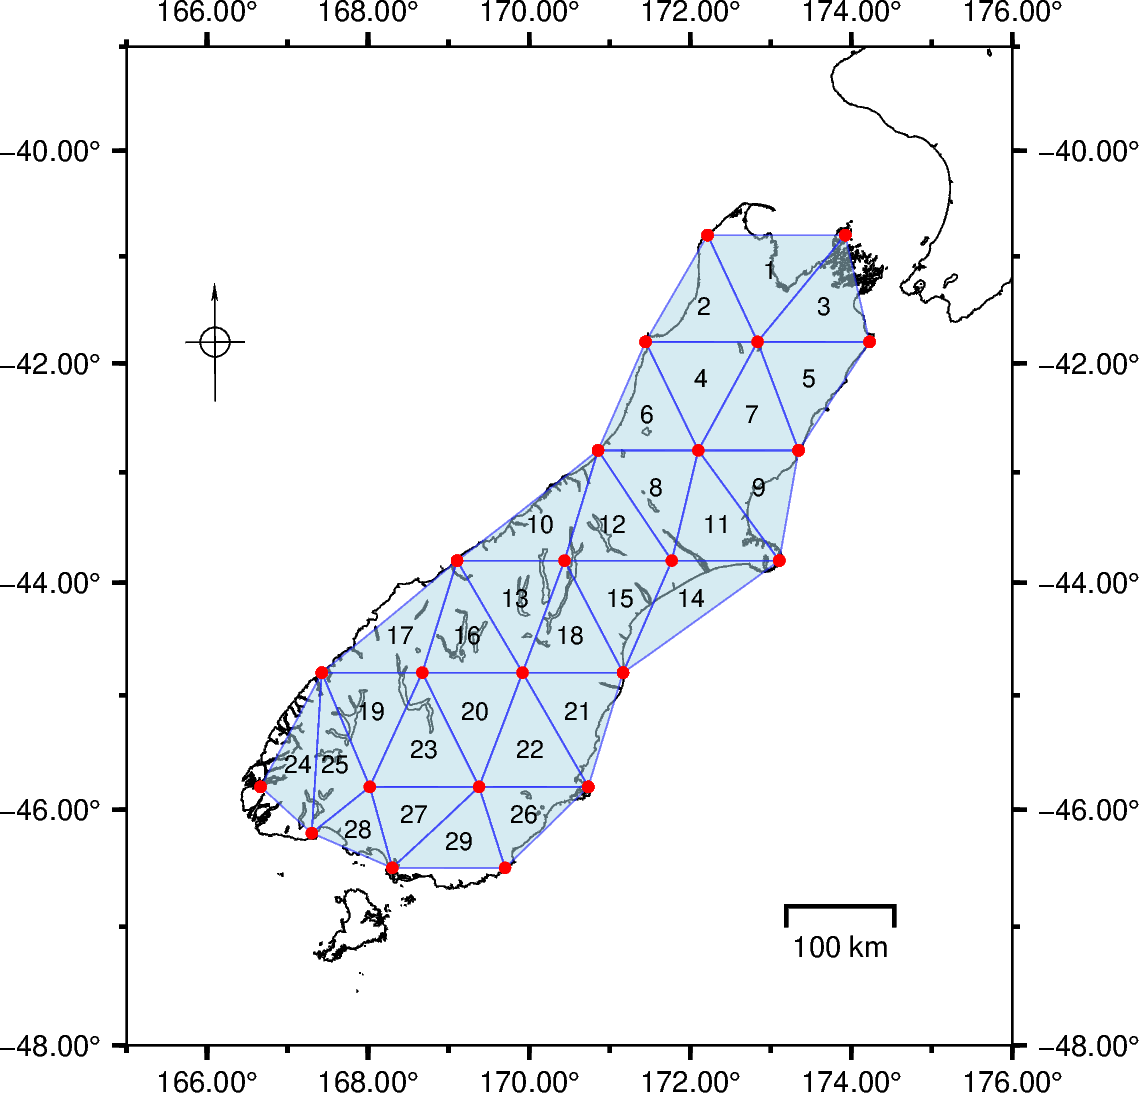

In [21]:
plot_using_mapdata = False

if plot_using_mapdata == True:
    # loading the mapdata
    map_data = (
        plotting.NZMapData.load(map_data_ffp) if map_data_ffp is not None else None
    )
else:
    map_data = None

fig = gen_region_fig(
    title=None,
    region=[165, 176, -48, -39],
    projection="M7.5c",
    map_data=map_data,
    coastline_color="black",
    coastline_pen_width=0.3,
    plot_topo=True,
    plot_roads=False,
    plot_highways=False,
    plot_kwargs={
        "highway_pen_width": 0.1,
        "coastline_pen_width": 0.01,
        "topo_cmap": "gray",  # etopo1 geo
        "topo_cmap_min": 0,
        "topo_cmap_max": 3700,
        "topo_cmap_inc": 250,
        "topo_cmap_reverse": True,
    },
    config_options=dict(
        MAP_FRAME_TYPE="graph",
        FORMAT_GEO_MAP="ddd.xx",
        MAP_GRID_PEN="0.5p,gray",
        MAP_TICK_PEN_PRIMARY="1p,black",
        MAP_FRAME_PEN="thinner,black",
        MAP_FRAME_AXES="WSEN",
        FONT_ANNOT_PRIMARY="7p,Helvetica,black",
        FONT_LABEL="7p",  # Font size for axis labels
        FONT_TITLE="9p",  # Font size for the title
    ),
)
fig.basemap(map_scale="jBR+w100k+o1c/1c", rose="JTL+w1.0c+o0.5c/2c")

land_points["lon"] = land_points["lon"].astype(float)
land_points["lat"] = land_points["lat"].astype(float)

for poly in triangles_df["geometry"]:
    if poly.is_empty:
        continue
    x, y = poly.exterior.coords.xy
    fig.plot(x=x, y=y, pen="0.3p,blue", fill="lightblue", close=True, transparency=50)
    

for _, row in triangles_df.iterrows():  # or triangles_df.iterrows()
    if row["geometry"].is_empty:
        continue
    centroid = row["geometry"].centroid
    fig.text(
        x=centroid.x,
        y=centroid.y,
        text=str(row["spatial_id"]),  # or row["triangle_id"]
        font="6p,Helvetica,black",
        justify="CM"
    )

    
for _, gp in land_points.iterrows():
    fig.plot(x=gp["lon"], y=gp["lat"], style="c0.1c", fill="red")

fig1= fig
fig1.show()



# Disaggregation of Grid Points Using CS200

## Path and directory works

In [22]:
data_version = "combined_v20p6_v24p8_v20p9_v24p9"
sim_200_dir = f"/mnt/hypo_data/mab419/Cybershake_Data/{data_version}"  # dpath to simulation data
sim_200_pickle_dir = f"/mnt/hypo_data/mab419/Cybershake_Data_Pickle/{data_version}"  # dpath to hazard calculation data
sim_200_hazard_pickle_dir = f"/mnt/hypo_data/mab419/Cybershake_Hazard_Data/{data_version}" # dpath to precalculated simulation hazard dictionary pickle

## Define Global Functions

In [23]:
# Define function for calculating multi site cybershake hazard

def compute_sim_hazard_multisite(
    fault_im_dict: dict[str, xr.DataArray],
    flt_erf_df: pd.DataFrame,
    stations: Sequence[str],
    ims: Sequence[str],
    
):
    """
    Computes the simulation-based seismic hazard
    for a multiple sites.

    Parameters
    ----------
    fault_im_dict: dict
        The IM data for each fault as a DataArray
        [output of the seismic_hazard_analysis.nshm_2010.load_sim_im_data function]
    flt_erf_df: pd.DataFrame
        The 2010 NSHM fault ERF data.
        [output of the seismic_hazard_analysis.nshm_2010.load_nhm_df function]
    stations: Sequence of str
        The stations for which to compute the hazard
    ims: Sequence of str
        The IMs for which to compute the hazard

    Returns
    -------
    hazard_results: dict
        The hazard curve for each IM
    """
    
    im_hazard_dic = {
        im: pd.DataFrame(
            index=stations,
            columns=sha.utils.get_im_levels(im).tolist(),
        )
        for im in ims
    }

    for st in stations:
        try:
            site_im_df = sha.nshm_2010.get_sim_site_ims(fault_im_dict, st)
        except (ValueError, TypeError) as e:
            print(f"Caught an error: {e} \non station {st}")
        
        im_hazard = sha.nshm_2010.compute_sim_hazard(site_im_df, flt_erf_df, ims)

        for im, value in im_hazard.items():
            valid_columns = im_hazard_dic[im].columns.intersection(value.index)
            im_hazard_dic[im].loc[st, valid_columns] = value[valid_columns].values

    return im_hazard_dic

In [24]:
# Define function to calculate hazard disaggragation for a single station
def calculate_fault_disaggregated_sim_hazard(
    station: str,
    im: str,
    fault_im_dict: dict[str, xr.DataArray],
    flt_erf_df: pd.DataFrame,
    cs_im_hz_dic: dict[str, pd.DataFrame] = None,
    specified_im_levels: np.ndarray[float] = None,
):
    """
    Computes the fault-by-fault disaggregation of the simulation-based seismic hazard
    for a single station and a given P(fult_i|IM>im_levels) for all faults that the 
    station was included in their simulation domain.
    See equation 7.10 of the "Seismic Hazard and Risk Analysis" book.

    This function estimates the contribution of each fault to the total hazard by comparing 
    the exceedance probabilities due to individual fault simulations against the total hazard curve.

    Parameters
    ----------
    station : str
        The name of the station (must match the index in `cs_im_hz_dic` and site data in `fault_im_dict`).
    
    im : str
        The intensity measure type (e.g., 'pSA_0.01') for which disaggregation is performed.

    fault_im_dict : dict[str, xr.DataArray]
        Dictionary of simulation results for each fault, as returned by: 
        [seismic_hazard_analysis.nshm_2010.load_sim_im_data].
        

    flt_erf_df : pd.DataFrame
        DataFrame containing the fault source model, including recurrence intervals.
        [Output of the `qcore.nhm.load_nhm_df` function]

    cs_im_hz_dic : dict[str, pd.DataFrame], optional
        Dictionary containing precomputed Cybershake hazard curves for all stations and IMs
        or read from the saved pickle file generated by: 
        [calculate_cybershake_hazard_all_stations_parallel.py] script.
        - If not provided, hazard values will be recomputed from `fault_im_dict` and `flt_erf_df`.
        - If the default im_levels are not used (specific im_levels are introdeuced), 
          the pre-calculated values are ignored and the hazard values are recalculated.

    im_levels : np.ndarray of float, optional
        Specific IM levels for which disaggregation is to be calculated.
        If not provided, default levels from `sha.utils.get_im_levels(im)` are used.

    Returns
    -------
    fault_disagg_df : pd.DataFrame
        A DataFrame with shape [n_faults x n_im_levels] representing the disaggregated
        hazard contribution of each fault to the total exceedance rate at the station.
        Only faults that the station was included in their simulation domain will be included,
        even if the fault has zero contribution to the specified hazard im_level.

    Raises
    ------
    ValueError
        If total hazard is zero for an IM level but the fault contribution is non-zero (division by zero).
    """
    
    
    if not specified_im_levels:
        im_levels = sha.utils.get_im_levels(im)
    else:
        im_levels = specified_im_levels

    site_im_df = sha.nshm_2010.get_sim_site_ims(fault_im_dict, station)

    if not cs_im_hz_dic:
        site_cs_im_hz_dic = sha.nshm_2010.compute_sim_hazard(site_im_df, flt_erf_df, [im], {im: im_levels})
        site_cs_im_hz_sr = site_cs_im_hz_dic[im]
    else:
        if specified_im_levels is not None:
            site_cs_im_hz_dic = sha.nshm_2010.compute_sim_hazard(site_im_df, flt_erf_df, [im], {im: im_levels})
            site_cs_im_hz_sr = site_cs_im_hz_dic[im]
            print("Because defult im_levels are not used, the hazard values are recalculated and pre-calculate values are ignored.")
        else:
            site_cs_im_hz_dic = cs_im_hz_dic
            site_cs_im_hz_sr = site_cs_im_hz_dic[im].loc[station]

    flt_erf_df["recur_rate_median"] = 1 / flt_erf_df["recur_int_median"]
    im_values_sr = site_im_df[im]
    gm_excd_prob_df = sha.hazard.non_parametric_gm_excd_prob(
        im_levels=im_levels, im_values=im_values_sr
    )
    fault_disagg_df = pd.DataFrame(
        index=gm_excd_prob_df.index, columns=gm_excd_prob_df.columns
    )
    for fault in gm_excd_prob_df.index:
        # ___________________________These lines are true but replaced by the following block of code to increase speed___________________________
        # for level in im_levels:
        #     prob_excd_im_level_giv_flt = gm_excd_prob_df.loc[fault, level]
        #     flt_rec_rate = flt_erf_df.loc[fault, "recur_rate_median"]
        #     cs_im_exc_rate = cs_im_hz_dic[im].loc[station, level]

        #     if cs_im_exc_rate == 0:
        #         if prob_excd_im_level_giv_flt == 0:
        #             fault_disagg_df.loc[fault, level] = 0
        #         else:
        #             raise ValueError(
        #                 f"Station {station} has 0 hazard for IM level {level} while fault {fault} has non-zero probability of exceeding this level."
        #             )
        #     else:
        #         fault_disagg_df.loc[fault, level] = (
        #             prob_excd_im_level_giv_flt * flt_rec_rate / cs_im_exc_rate
        #         )

        # Extract all required values as arrays
        prob_excd_im_level_giv_flt = (
            gm_excd_prob_df.loc[fault, im_levels].astype(float).values
        )
        flt_rec_rate = np.full_like(
            prob_excd_im_level_giv_flt,
            flt_erf_df.loc[fault, "recur_rate_median"],
            dtype=float,
        )
        cs_im_exc_rate = site_cs_im_hz_sr.loc[im_levels].astype(float).values

        # Initialize result array
        result = np.zeros_like(prob_excd_im_level_giv_flt)

        # Handle non-zero cs_im_exc_rate
        nonzero_mask = cs_im_exc_rate != 0
        result[nonzero_mask] = (
            prob_excd_im_level_giv_flt[nonzero_mask] * flt_rec_rate[nonzero_mask]
        ) / cs_im_exc_rate[nonzero_mask]

        # Handle 0/0 → result = 0
        zero_div_mask = (cs_im_exc_rate == 0) & (prob_excd_im_level_giv_flt == 0)
        result[zero_div_mask] = 0

        # Handle x/0 → raise or log
        invalid_mask = (cs_im_exc_rate == 0) & (prob_excd_im_level_giv_flt != 0)
        if np.any(invalid_mask):
            raise ValueError(
                f"Station {station} has 0 hazard for some IM levels "
                f"while fault {fault} has non-zero probability of exceedance."
            )

        # Assign the result back to the DataFrame row
        fault_disagg_df.loc[fault, im_levels] = result

    return fault_disagg_df

## Load CS200m Results

### Load Simulation Data from Pickle

In [25]:
file_name = "Cybershake_fault_im_data.pkl"
file_path = os.path.join(sim_200_pickle_dir, file_name)
with open(file_path, "rb") as file:
    fault_im_data = pickle.load(file)

print("Dictionary loaded successfully")

Dictionary loaded successfully


### Loading Pre-Calculated Simulation Hazard 

In [26]:
file_name = "Cybershake_hazard_data.pkl"
file_path = os.path.join(sim_200_hazard_pickle_dir, file_name)
with open(file_path, "rb") as file:
    total_cs_im_hz_dic = pickle.load(file)

print("Dictionary loaded successfully")

Dictionary loaded successfully


### CS Fault Contribution

In [27]:

im_of_interest = "pSA_5.0"

points_disagg_dict = { point: None for point in sorted_points_df['closest_station'].unique().tolist() }
for station_of_interest in sorted_points_df['closest_station'].unique():
    
    cs_fault_contribution_df = calculate_fault_disaggregated_sim_hazard(
        station=station_of_interest,
        im=im_of_interest,
        fault_im_dict=fault_im_data,
        flt_erf_df=flt_erf_df,
        # cs_im_hz_dic=total_cs_im_hz_dic,
    )

    cs_contributing_faults = cs_fault_contribution_df[
        cs_fault_contribution_df.sum(axis=1) > 0
    ].index

    cs_contribution_ratio = pd.DataFrame(index=cs_contributing_faults, columns=["Curve_Area", "Contribution_Ratio"])
    temp_df = cs_fault_contribution_df.loc[cs_contributing_faults].copy()
    for flt in cs_contributing_faults:
        im_level_values = np.array(cs_fault_contribution_df.columns)
        diff_im_level_values = np.diff(im_level_values)
        diff_im_level_values = np.insert(diff_im_level_values, 0, diff_im_level_values[0])
        log_diff_im_level_values = np.log10(diff_im_level_values)
        ff = temp_df.loc[flt].multiply(log_diff_im_level_values)
        cs_contribution_ratio.loc[flt, ['Curve_Area']] = abs(ff.sum())

    cs_contribution_ratio['Contribution_Ratio'] = cs_contribution_ratio['Curve_Area'] / cs_contribution_ratio['Curve_Area'].sum()
    cs_contribution_ratio.sort_values(by="Contribution_Ratio", ascending=False, inplace=True)
    cs_contribution_ratio['Cumulative_Contribution_Ratio'] = cs_contribution_ratio['Contribution_Ratio'].cumsum()
    
    points_disagg_dict[station_of_interest] = cs_contribution_ratio

    # deag_cs_hz_curve_dic = {flt: None for flt in cs_contributing_faults}

    # for flt in cs_contributing_faults:
    #     deag_cs_hz_curve_dic[flt] = compute_sim_hazard_multisite(
    #         fault_im_dict={flt: fault_im_data[flt]},
    #         flt_erf_df=flt_erf_df,
    #         stations=[station_of_interest],
    #         ims=[im_of_interest],
    #     )[im_of_interest]


## Identifying Influencing Faults

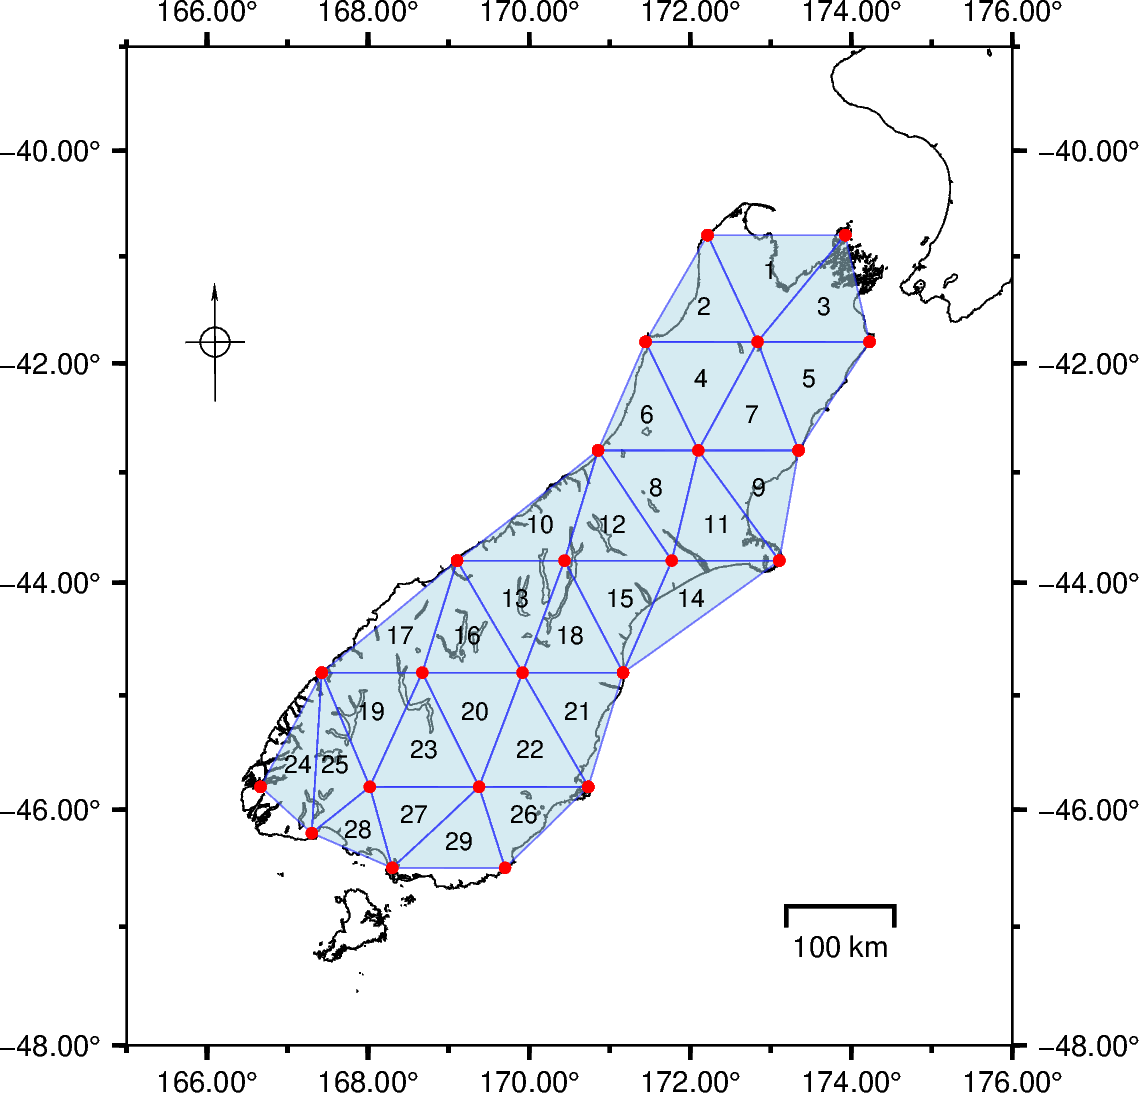

In [28]:
fig1.show()

### Define Tiles

In [29]:
include_new_faults = False  # Whether to include new faults in the analysis

CCR = 80 # Maximum Cumulative Contribution Ratio to consider (%)

Tiles_Of_Interest = [
     1,
     2,
     3,
     4,
     5,
     6,
     7,
     8,
     9,
     10,
     11,
     12,
     13,
     14,
     15,
     16,
     17,
     18,
     19,
     20,
     21,
     22,
     23,
     24,
     25,
     26,
     27,
     28,
     29,
]


### Calculations

In [30]:
stations_of_interest = []
for tile in Tiles_Of_Interest:
    if tile not in triangles_df['spatial_id'].values:
        print(f"Tile {tile} not found in triangles_df")
        continue
    stations_of_interest.extend(
        triangles_df.loc[triangles_df['spatial_id'] == tile, 'station_ids'].values[0]
    )
stations_of_interest = list(set(stations_of_interest))

influencing_faults_df = pd.DataFrame(columns=["station", "fault", "Cumulative_Contribution_Ratio"])
for station in stations_of_interest:
    if station not in points_disagg_dict:
        print(f"Station {station} not found in points_disagg_dict")
        continue
    tempdf = points_disagg_dict[station].copy()
    tempdf = tempdf[tempdf['Cumulative_Contribution_Ratio'] <= CCR / 100]
    tempdf['station'] = station
    tempdf.reset_index(inplace=True)
    tempdf.rename(columns={'index': 'fault'}, inplace=True)
    tempdf = tempdf[['station', 'fault', 'Cumulative_Contribution_Ratio']]
    influencing_faults_df = pd.concat([influencing_faults_df, tempdf], ignore_index=True)
    
influencing_faults_df = influencing_faults_df.groupby("fault")["Cumulative_Contribution_Ratio"].sum().reset_index()
influencing_faults_df.rename(columns={"Cumulative_Contribution_Ratio": "Base_CCR"}, inplace=True)
influencing_faults_df['contribution_rario'] = influencing_faults_df['Base_CCR'] / influencing_faults_df['Base_CCR'].sum() 
influencing_faults_df.sort_values(by="contribution_rario", ascending=False, inplace=True)
influencing_faults_df.drop(columns=["Base_CCR"], inplace=True)
influencing_faults_df = influencing_faults_df.merge(flt_erf_df[["mw"]], how="left", left_on="fault", right_index=True)
influencing_faults_df = influencing_faults_df.merge(FV[["number_of_realizations", "realization_tag"]], how="left", left_on="fault", right_index=True)
influencing_faults_df['required_number_of_realizations'] = influencing_faults_df.apply(
    lambda row: np.round(0.37 * row["number_of_realizations"], decimals=0).astype(int) if row["realization_tag"] == "incomplete" else 0, axis=1
) # The coefficient 0.37 is taken from the Cybershake documentation, where we calculated the number of new realizations needed to reach corrcect truncated normal distribution
influencing_faults_df.set_index("fault", inplace=True)

for index, row in influencing_faults_df.iterrows():
    if pd.isna(row['realization_tag']):
        influencing_faults_df.loc[index, 'realization_tag'] = 'undone'
        if include_new_faults:
            influencing_faults_df.loc[index, 'required_number_of_realizations'] = estimate_number_of_realizations(row['mw'])
        else:
            influencing_faults_df.loc[index, 'required_number_of_realizations'] = 0

### Plot Outputs

In [32]:
selected_triangles_df = triangles_df[triangles_df['spatial_id'].isin(Tiles_Of_Interest)].copy()
selected_land_points = []
for _, row in selected_triangles_df.iterrows():
    selected_land_points.extend(row['point_ids'])
selected_land_points = list(set(selected_land_points))
selected_land_points = sorted_points_df[sorted_points_df['point_id'].isin(selected_land_points)].copy()

plot_using_mapdata = False

if plot_using_mapdata == True:
    # loading the mapdata
    map_data = (
        plotting.NZMapData.load(map_data_ffp) if map_data_ffp is not None else None
    )
else:
    map_data = None

fig = gen_region_fig(
    title=None,
    region=[165, 176, -48, -39],
    projection="M7.5c",
    map_data=map_data,
    coastline_color="gray",
    coastline_pen_width=0.1,
    plot_topo=True,
    plot_roads=False,
    plot_highways=False,
    plot_kwargs={
        "highway_pen_width": 0.1,
        "coastline_pen_width": 0.01,
        "topo_cmap": "gray",  # etopo1 geo
        "topo_cmap_min": 0,
        "topo_cmap_max": 3700,
        "topo_cmap_inc": 250,
        "topo_cmap_reverse": True,
    },
    config_options=dict(
        MAP_FRAME_TYPE="graph",
        FORMAT_GEO_MAP="ddd.xx",
        MAP_GRID_PEN="0.5p,gray",
        MAP_TICK_PEN_PRIMARY="1p,black",
        MAP_FRAME_PEN="thinner,black",
        MAP_FRAME_AXES="WSEN",
        FONT_ANNOT_PRIMARY="7p,Helvetica,black",
        FONT_LABEL="7p",  # Font size for axis labels
        FONT_TITLE="9p",  # Font size for the title
    ),
)
fig.basemap(map_scale="jBR+w100k+o1c/1c", rose="JTR+w1.0c+o3.5c/0.1c")

selected_land_points["lon"] = selected_land_points["lon"].astype(float)
selected_land_points["lat"] = selected_land_points["lat"].astype(float)

for poly in selected_triangles_df["geometry"]:
    if poly.is_empty:
        continue
    x, y = poly.exterior.coords.xy
    fig.plot(x=x, y=y, pen="0.3p,blue", fill="slateblue", close=True, transparency=80)


for _, row in selected_triangles_df.iterrows():  # or selected_triangles_df.iterrows()
    if row["geometry"].is_empty:
        continue
    centroid = row["geometry"].centroid
    fig.text(
        x=centroid.x,
        y=centroid.y,
        text=str(row["spatial_id"]),  # or row["triangle_id"]
        font="6p,Helvetica,black",
        justify="CM"
    )


for _, gp in selected_land_points.iterrows():
    fig.plot(x=gp["lon"], y=gp["lat"], style="c0.1c", fill="forestgreen")

for fault_name in influencing_faults_df.index:

    fault_object = sha.nshm_2010.get_fault_objects(flt_erf[fault_name])
    for i in range(len(fault_object.planes)):
        ##create a shapely geometry for the plane
        ##(see https://github.com/ucgmsim/source_modelling/blob/ecf02f6d5d2fee4e8b8c5e9a1c3449a2d84789ec/source_modelling/sources.py#L403 )
        subfault_polygon = fault_object.planes[i].geometry
        lats, lons, depth = zip(*[coords.nztm_to_wgs_depth(np.array(coord)) for coord in subfault_polygon.exterior.coords])
        long_trace, lat_trace = zip(*flt_erf[fault_name].trace.tolist())
        if influencing_faults_df.loc[fault_name, "realization_tag"] == "undone":
            fig.plot(x=long_trace, y=lat_trace, pen="0.5p,black")
        elif influencing_faults_df.loc[fault_name, "realization_tag"] == "good":
            fig.plot(x=long_trace, y=lat_trace, pen="0.5p,blue")
        elif influencing_faults_df.loc[fault_name, "realization_tag"] == "mixed":
            fig.plot(x=long_trace, y=lat_trace, pen="0.5p,blue")
        elif influencing_faults_df.loc[fault_name, "realization_tag"] == "incomplete":
            fig.plot(x=long_trace, y=lat_trace, pen="0.5p,red")

text_lines = [
    f"# of Faults: {len(influencing_faults_df.index)}",
    f"# of Completed Faults: {len(influencing_faults_df[influencing_faults_df['realization_tag'] == 'good'].index) + len(influencing_faults_df[influencing_faults_df['realization_tag'] == 'mixed'].index)}",
    f"# of Incomplete Faults: {len(influencing_faults_df[influencing_faults_df['realization_tag'] == 'incomplete'].index)}",
    f"# of Undone Faults: {len(influencing_faults_df[influencing_faults_df['realization_tag'] == 'undone'].index)}",
    f"# of Required Realizations: {influencing_faults_df['required_number_of_realizations'].sum()}"
]

x = 165.3
y = -40.5
line_spacing = 0.4  # degrees; adjust to fit visually

for i, line in enumerate(text_lines):
    fig.text(
        x=x,
        y=y - i * line_spacing,
        text=line,
        font="7p,Helvetica,black",
        justify="TL"
    )


## Creating a sythetic legend:)
fig.plot(x=[190, 200], y=[-40, -40], pen="0.5p,dimgray", label="NSHM Faults (Undone)")
fig.plot(x=[190, 200], y=[-40, -40], pen="0.5p,blue", label="Completed Faults")
fig.plot(x=[190, 200], y=[-40, -40], pen="0.5p,red", label="Incomplete Faults")


fig.legend(position="JTL+o0.1c/-1.2c+jBL", box="+gwhite+p0.1p,black")

fig.show()

AttributeError: 'numpy.ndarray' object has no attribute 'nztm_to_wgs_depth'

In [ ]:
FV['number_of_realizations'].sum()